## Code for solving the matching problem.

We need to define four fields which will evolve with the RK scheme.

For the left region we have 3 fields, $\phi_L$, $vp$ and $vm$
For the right region also solve for 3 fields, $S$, $W$, and $\phi_R$.





In [14]:
using Plots
using FileIO
using JLD2
using Base.Threads
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
using LaTeXStrings

nthreads = 2


In [15]:
include("aux_functions.jl")

bump_x (generic function with 1 method)

We have implemented three configurations: 

2 are with L=R=1, one has a bump in L (l_pulse), the other a bump on R, (r_pulse).

The other configuration has a small region for L and a constant size for R. So this is closer to the problem with a cone. 
In this case we keep the number of points in L fixed (and make L smaller with resolution). We need to move slightly the bump so that it is allways in the same place (but shifted in time)

In [16]:
l_pulse = false
r_pulse = false
c_pulse = false
#r_pulse = true
c_pulse = true

if l_pulse
    run_name = "l_pulse_"
elseif r_pulse
    run_name = "r_pulse_"
elseif c_pulse
    run_name = "c_pulse_"
end

if l_pulse || r_pulse
    Nl = 401; Nr = 401 #points to the left and rigth regions
    L = 1.0 #size of left side 
    R = 1.0 #size of right side
    dl = L/(Nl-1)
    dr = R/(Nr-1)
elseif c_pulse
    Nl = 11; Nr = 801
    R = 2.0 #size of right side
    dr = R/(Nr-1)
    dl = dr 
    L  = dl*(Nl-1)
end

u = zeros(3Nl+3Nr);
ρ_L = zeros(Nl)
ρ_R = zeros(Nr) 

run_name = run_name * "$(Nl)_$(Nr)"
par_grid = (Nl, L, dl, Nr, R, dr)

(11, 0.025, 0.0025, 801, 2.0, 0.0025)

### The initial data. 

We shall use first a simple initial data consisting of a bump to the left in the right side. The rest is zero.

In [17]:




if r_pulse
    S = view(u,3Nl+Nr+1:3Nl+2Nr)
    ϕ_R = view(u,3Nl+1:3Nl+Nr)
    x0 = L + 0.2
    x1 = L + 0.4
    p_bump = 4
    A = 1.0
    for i in 1:Nr 
        r = L + dr*(i-1) 
        S[i] = bump_x(r,x0,x1,p_bump,A)
        ϕ_R[i] = bump(r,x0,x1,p_bump,A)
        plot(S)
    end
end

if l_pulse

    x0 =  0.6
    x1 =  0.8
    p_bump = 4
    A = 1.0

    vp = view(u,Nl+1:2Nl)
    ϕ_L = view(u,1:Nl)

    for i in 1:Nl
        r = dl*(i-1) 
        #u[3*Nl+Nr+i] = bump(r,x0,x1,p_bump,A)
        vp[i] = 2*bump_x(r,x0,x1,p_bump,A)
        ϕ_L[i] = bump(r,x0,x1,p_bump,A)
        plot(ϕ_L)
    end
end

if c_pulse
    S = view(u,3Nl+Nr+1:3Nl+2Nr)
    ϕ_R = view(u,3Nl+1:3Nl+Nr)
    x0 = L + 0.2 #+ sqrt(2)*(Nl-1)*dl
    x1 = x0 + 0.2
    p_bump = 4
    A = 1.0
    for i in 1:Nr 
        r = L + dr*(i-1) 
        S[i] = bump_x(r,x0,x1,p_bump,A)
        ϕ_R[i] = bump(r,x0,x1,p_bump,A)
        plot(S)
    end
end

par_init = (x0,x1,p_bump,A)



(0.225, 0.42500000000000004, 4, 1.0)

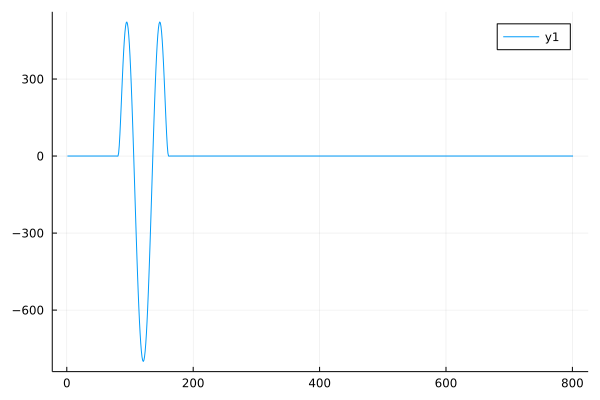

In [18]:
par_Dx_r = (Nr, dr)
dS = D4x_SBP_ts(S,par_Dx_r,Qd)
plot(dS)

In [19]:
ρ_L = zeros(Nl)
ρ_R = zeros(Nr)
du = zeros(3Nl+3Nr)

p_F = Nl, dl, Nr, dr, ρ_L, ρ_R

(11, 0.0025, 801, 0.0025, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [20]:
t_i = 0.0
if l_pulse
    t_f = 2.0
    M = 1601
    dt = (t_f - t_i)/(M-1)
    M_d = 101
elseif r_pulse
    t_f = 3.0
    M = 1801
    dt = (t_f - t_i)/(M-1)
    M_d = 151
elseif c_pulse 
    t_f = 2.0
    M = 1801
    dt = (t_f - t_i)/(M-1)
    M_d = 181
end
t = t_i
dt_d = (t_f - t_i)/(M_d-1)

0.011111111111111112

In [21]:
k1 = zeros(3Nl+3Nr)
k2 = zeros(3Nl+3Nr)
k3 = zeros(3Nl+3Nr)
k4 = zeros(3Nl+3Nr)
par_RK = (k1, k2, k3, k4)
par_evolv = (t_i, t_f, M, dt, M_d, dt_d)

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "par_init" => par_init)
file_name = "Results/"* run_name * ".jld2"
#rm(file_name)
j = 1
tiempo = @sprintf("%05d", j)
field_name = "u"

save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

jldopen(file_name, "a+") do file
    file[field_name * "/u_$(tiempo)"] = u;
end

2436-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [22]:


for k in 2:M
    RK4_Step!(F!,u,t,dt,p_F,par_RK)
    global t = t + dt
    if (k-1) % (M÷(M_d-1)) == 0
        local j = (k-1)÷(M÷(M_d-1))+1
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
        end
        println("t=$t")
    end
end


t=0.011111111111111112
t=0.022222222222222223
t=0.03333333333333333
t=0.044444444444444446
t=0.05555555555555556
t=0.06666666666666665
t=0.0777777777777777
t=0.08888888888888874
t=0.09999999999999978
t=0.11111111111111083
t=0.12222222222222187
t=0.13333333333333303
t=0.1444444444444442
t=0.1555555555555554
t=0.16666666666666657
t=0.17777777777777776
t=0.18888888888888894
t=0.20000000000000012
t=0.2111111111111113
t=0.2222222222222225
t=0.23333333333333367
t=0.24444444444444485
t=0.25555555555555604
t=0.2666666666666672
t=0.2777777777777784
t=0.2888888888888896
t=0.30000000000000077
t=0.31111111111111195
t=0.32222222222222313
t=0.3333333333333343
t=0.3444444444444455
t=0.3555555555555567
t=0.36666666666666786
t=0.37777777777777904
t=0.3888888888888902
t=0.4000000000000014
t=0.4111111111111126
t=0.4222222222222238
t=0.43333333333333496
t=0.44444444444444614
t=0.4555555555555573
t=0.4666666666666685
t=0.4777777777777797
t=0.48888888888889087
t=0.500000000000002
t=0.5111111111111126
t=0.52